# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №1

## №1 (20 баллов)

- Как и обещал, задачка по мотивам статьи, ссылка на которую есть в семинаре
- На ответах алгоритма $a(x)$ бъекты класса 0 распределены с плотностью $p(a) = \frac{3}{2} - a$, а объекты класса 1 - $p(a) = a + \frac{1}{2}$
    - Чему здесь равен `AUC ROC`. Помните, что просто числа в качестве ответа недостаточно. Покажите все 
    - Посчитайте также критерий качества `Gini`

## №2 (40 баллов)

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, make_scorer
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

Запомните, дети: так, как я сделал ячейкой ниже, делать нельзя

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/HW_002_001.txt')

In [ ]:
df.head()

State  Account length  ...  Customer service calls  Churn
0    KS             128  ...                       1  False
1    OH             107  ...                       1  False
2    NJ             137  ...                       0  False
3    OH              84  ...                       2  False
4    OK              75  ...                       3  False

[5 rows x 20 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [ ]:
df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = df['Churn'].astype('int').values
X = df.drop('Churn', axis=1).values

### Задание

- Ваше задание
    - Провести EDA анализ признаков, которые есть
    - Подумать над feature engineering, сформировать гипотезы
    - Зафиттить логистическую модель и пробит модель
    - Посмотреть на их метрики качества: псевдо $R^2$, confusion matrix, precision, recall, F1-score, ROC AUC
    - Какую модель вы бы выбрали?
    - Посмотреть на профиль среднего "клиента" (наблюдения). Какие переменные надо изменить, чтобы верояность ухода клиента снизилась?
    - Перейдем к предсказаниям:
        - У вас не всегда будут функции типа `LogisticRegressionCV`, поэтому почитайте про [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
        - Подумайте, какие еще признаки можно добавить в вашу модель. На этом этапе не бойтесь кол-ва признаков, чем больше, тем лучше. *{Дополнительно: почитайте про [`RFECV`](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py), попробуйте его применить}*
        - При наличии достаточного кол-ва наблюдений, хорошей стратегией является использование только части данных для расчета модели. Используя [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) выделите наблюдения для обучения.
        - Создайте стратифицированные фолды на обучающей выборке
        - На практике нам приходится выбирать между различными метриками качества. В этой задаче будем использовать ROC AUC
        - Используя `GridSearchCV` и [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression) подберите оптимальный гиперпараметр для l1, l2 регуляризаций. Помните, что вы хотите, чтобы оптимальный гиперпараметр был выбран согласно метрике ROC AUC. Почитайте, как это сделать в GridSearchCV
        - Нарисуйте графики, как меняется ваш score в зависимости от значения гиперпараметра

### EDA
Ну давайте графичков намутим, чоб нет

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


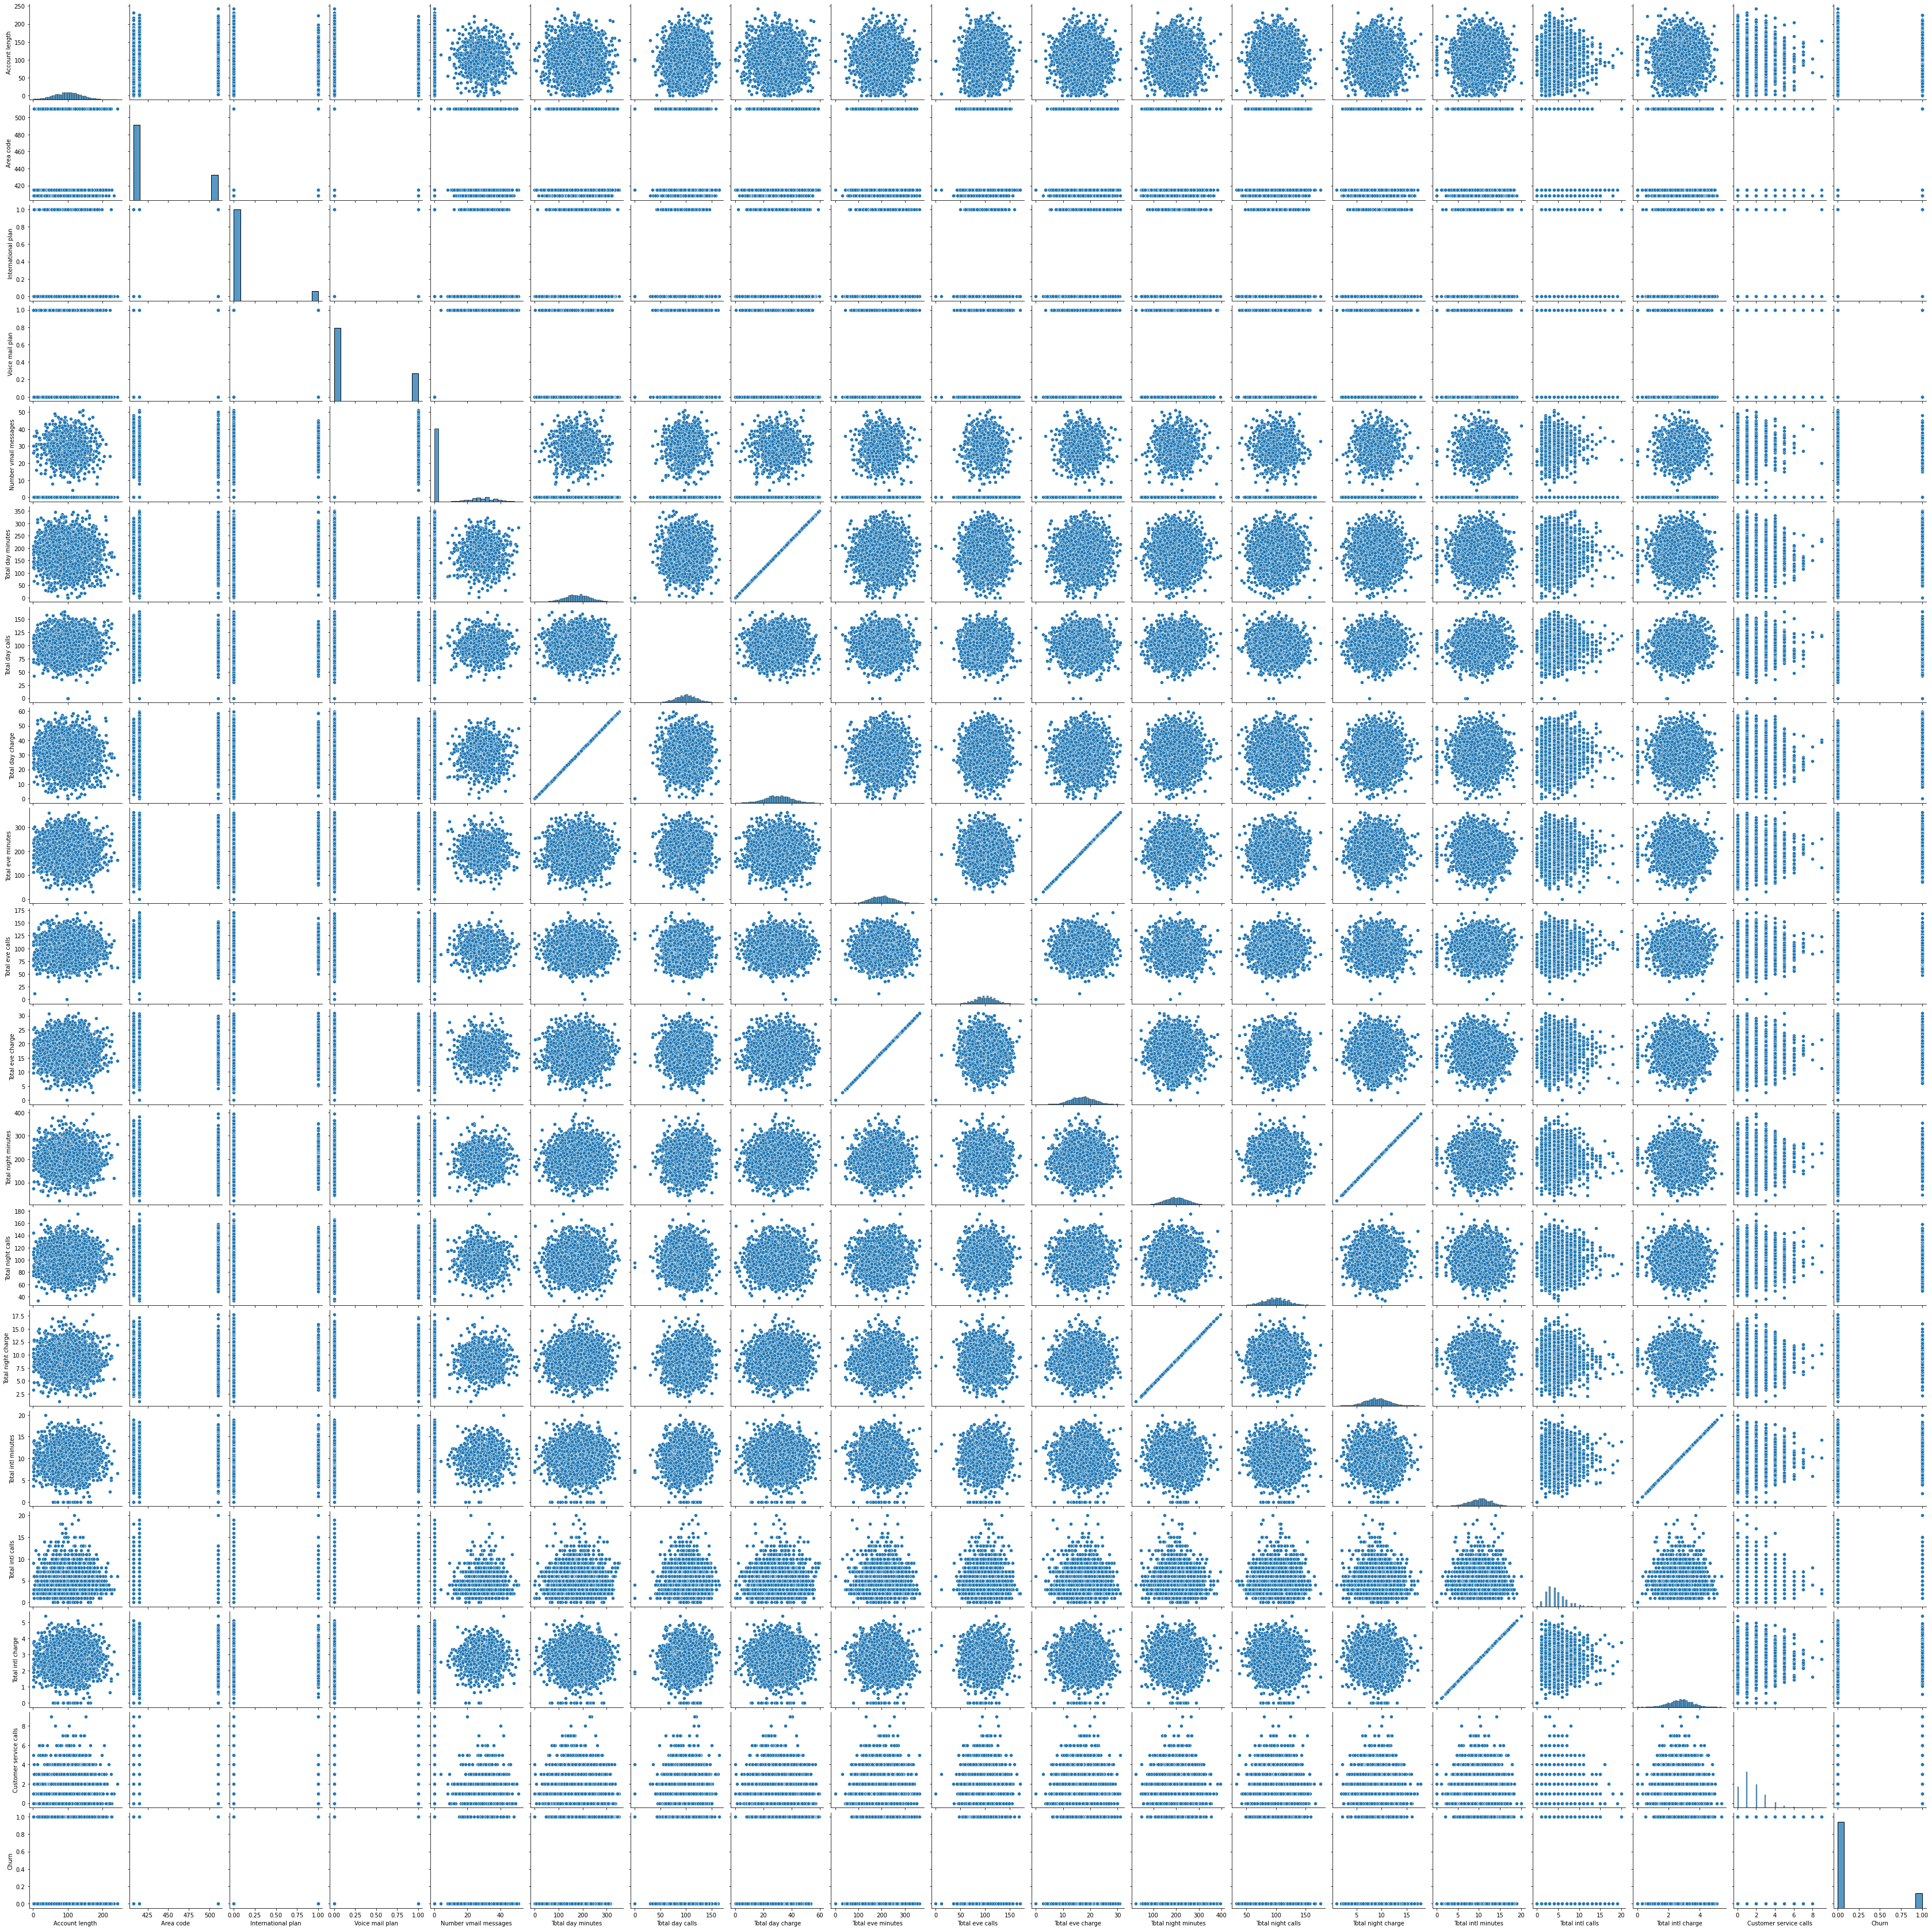

In [ ]:
sns.pairplot(df)

Никто:\
Абсолютно никто:\
Тимур: вот вам линейно скоррелированные признаки. Зафиттите туда логит.

### Feature engineering

Во-первых, видна несбалансированность целевой переменной. Посмотрим поближе:

In [ ]:
print(f'not_churned:\t\t {len(df[df["Churn"] == 0])}')
print(f'churned:\t\t {len(df[df["Churn"] == 1])}')
print(f'churn percentile:\t {round(len(df[df["Churn"] == 1]) / len(df) * 100)}')

not_churned:		 2850
churned:		 483
churn percentile:	 14


Да, дата нифига не сбалансирована. Мб есть разрывы по штатам?

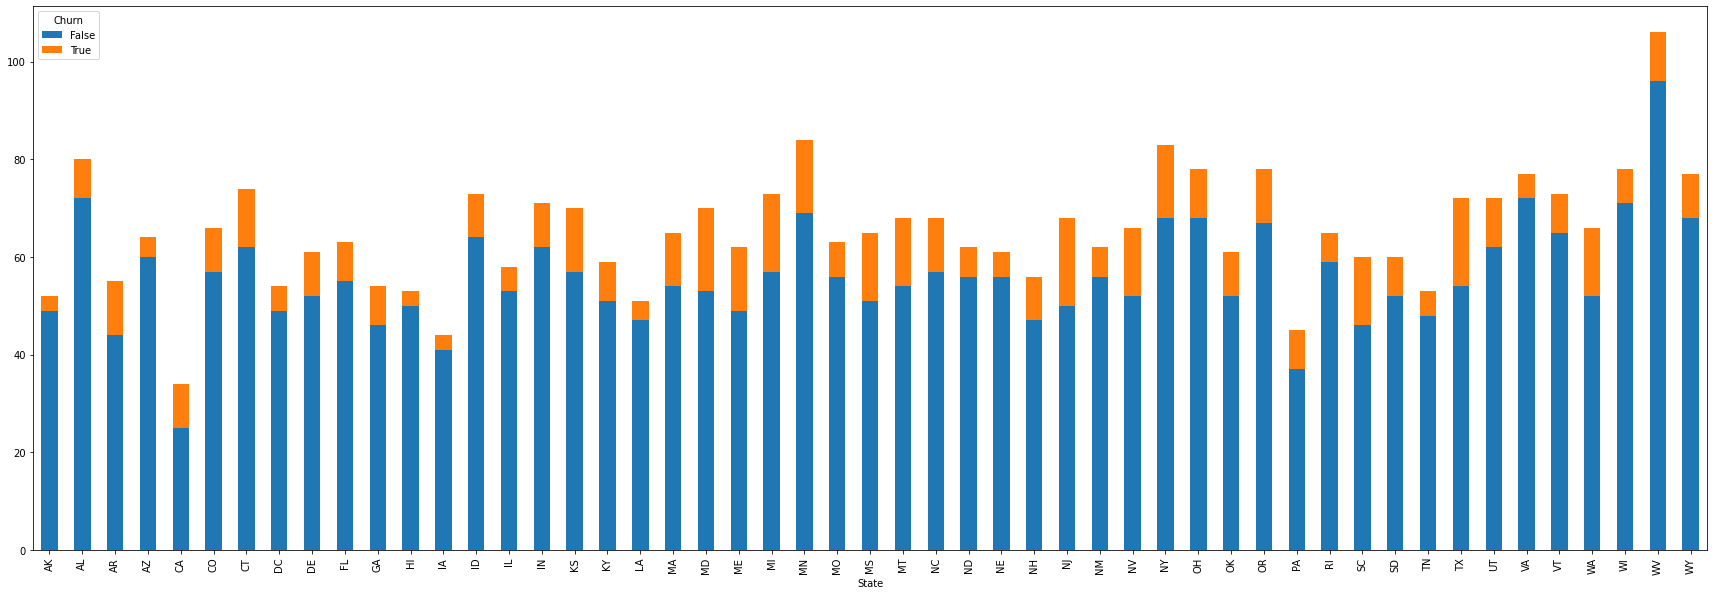

In [ ]:
df.groupby(['State', 'Churn']).size().unstack().plot(kind='bar', stacked=True, figsize=(30, 10))
plt.show()

А давайте цифровизуем штат

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df['State'])
df['State'] = le.transform(df['State'])

Посмотрим на разбиение по `Area code`

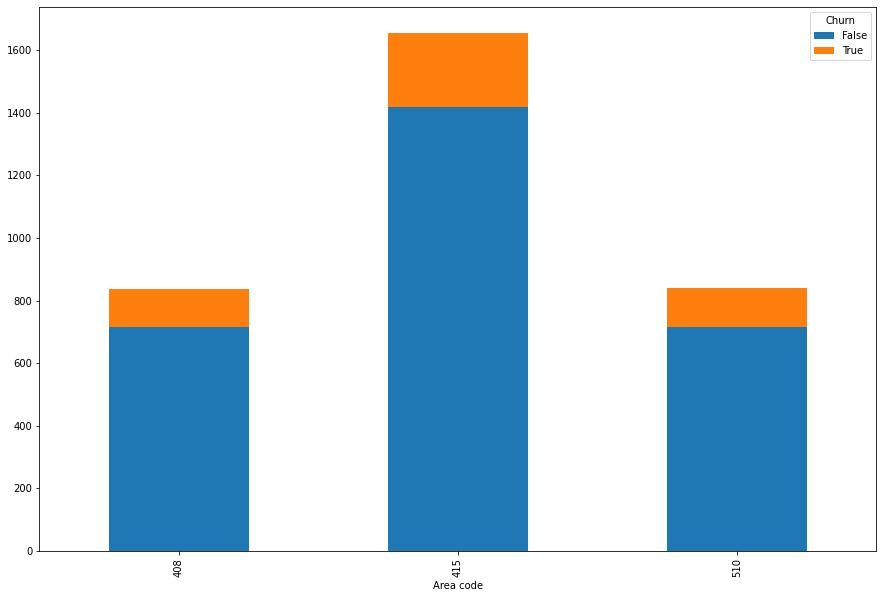

In [ ]:
df.groupby(['Area code', 'Churn']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 10))
plt.show()

Максимально информативно (нет)

Теперь я хочу посмотреть поближе на линейно зависимые признаки.

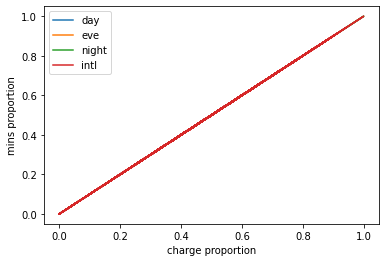

In [ ]:
time = [
        'day',
        'eve',
        'night',
        'intl',
]

for t in time:
    str_charge = 'Total ' + t + ' charge'
    str_mins = 'Total ' + t + ' minutes' 
    plt.plot(df[str_charge] / df[str_charge].max(), df[str_mins] / df[str_mins].max(), label=t)
plt.xlabel('charge proportion')
plt.ylabel('mins proportion')
plt.legend()
plt.show()

Получили идеальную линейку. Ы.\
Небольшой sum up:
- Хочу дропнуть минуты, потому что люблю деньги. В целом, всё равно, ибо тут околоидеальная линейка даже без выбросов.
- Ещё хочу подропать малоинформативные штуки вроде area code и планов.

Видимо, сначала надо фиттить без отсева фич (ведь так же, да?)

Если что, выполнение отсева есть в пункте предикты -> работа с признаками

### Фиттим логистическую и пробит модели.

In [ ]:
y = df['Churn'].astype('int').values
X = df.drop('Churn', axis=1).values

In [ ]:
logit_mod = sm.Logit(endog=y, exog=sm.add_constant(X)).fit()
logit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.323797
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3333
Model:                          Logit   Df Residuals:                     3313
Method:                           MLE   Df Model:                           19
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:                  0.2175
Time:                        19:06:39   Log-Likelihood:                -1079.2
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                5.404e-115
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4723      0.929     -9.117      0.000     -10.294      -6.651
x1             0.0015      0.004      0.397      0.692      -0.006       0.009
x2             0.0008      0.001      0.594      0.553      -0.002       0.004
x3            -0.0005      0.001     -0.370      0.712      -0.003       0.002
x4             2.0460      0.146     14.036      0.000       1.760       2.332
x5            -2.0160      0.575     -3.507      0.000      -3.143      -0.889
x6             0.0356      0.018      1.976      0.048       0.000       0.071
x7            -0.2382      3.276     -0.073      0.942      -6.658       6.182
x8             0.0032      0.003      1.154      0.249      -0.002       0.009
x9             1.4772     19.268      0.077      0.939     -36.288      39.243
x10            0.7844      1.637      0.479      0.632      -2.425       3.994
x11            0.0011      0.003      0.380      0.704      -0.004       0.007
x12           -9.1431     19.264     -0.475      0.635     -46.901      28.614
x13           -0.1132      0.877     -0.129      0.897      -1.833       1.606
x14            0.0007      0.003      0.246      0.805      -0.005       0.006
x15            2.5974     19.495      0.133      0.894     -35.612      40.806
x16           -4.2487      5.305     -0.801      0.423     -14.645       6.148
x17           -0.0931      0.025     -3.714      0.000      -0.142      -0.044
x18           16.0597     19.646      0.817      0.414     -22.445      54.565
x19            0.5144      0.039     13.083      0.000       0.437       0.591
==============================================================================
"""

In [ ]:
probit_mod = sm.Probit(endog=y, exog=sm.add_constant(X)).fit()
probit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.323810
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3333
Model:                         Probit   Df Residuals:                     3313
Method:                           MLE   Df Model:                           19
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:                  0.2174
Time:                        19:06:41   Log-Likelihood:                -1079.3
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                5.628e-115
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5434      0.496     -9.166      0.000      -5.515      -3.572
x1             0.0010      0.002      0.504      0.614      -0.003       0.005
x2             0.0005      0.001      0.627      0.530      -0.001       0.002
x3            -0.0003      0.001     -0.386      0.700      -0.002       0.001
x4             1.1770      0.083     14.265      0.000       1.015       1.339
x5            -1.0006      0.289     -3.463      0.001      -1.567      -0.434
x6             0.0175      0.009      1.917      0.055      -0.000       0.035
x7             0.1088      1.795      0.061      0.952      -3.408       3.626
x8             0.0015      0.001      1.009      0.313      -0.001       0.004
x9            -0.6003     10.556     -0.057      0.955     -21.290      20.089
x10            0.4958      0.894      0.555      0.579      -1.256       2.247
x11            0.0008      0.002      0.513      0.608      -0.002       0.004
x12           -5.7895     10.514     -0.551      0.582     -26.396      14.817
x13           -0.0376      0.476     -0.079      0.937      -0.970       0.895
x14            0.0003      0.002      0.207      0.836      -0.003       0.003
x15            0.8761     10.571      0.083      0.934     -19.843      21.595
x16           -2.1401      2.876     -0.744      0.457      -7.777       3.497
x17           -0.0441      0.013     -3.415      0.001      -0.069      -0.019
x18            8.0897     10.653      0.759      0.448     -12.789      28.968
x19            0.2916      0.021     13.822      0.000       0.250       0.333
==============================================================================
"""

### Смотрим на метрики качества

Посмотреть на их метрики качества: псевдо $R^2$, confusion matrix, precision, recall, F1-score, ROC AUC

#### Pseudo-$R^2$ 
Совпал до 3го знака, пока скипнем (да и Тимур рассказывал, что это не то чтобы основная метрика для классификации)

#### Confusion matrix:

Сделаем предикты

In [ ]:
y_pred_logit = np.where(logit_mod.predict(sm.add_constant(X)) > 0.5, 1, 0)
y_pred_probit = np.where(probit_mod.predict(sm.add_constant(X)) > 0.5, 1, 0)

Confusion matrix для logit

In [ ]:
confusion_matrix(y_true = df['Churn'], y_pred=y_pred_logit)

array([[2769,   81],
       [ 378,  105]])

Confusion matrix для probit

In [ ]:
confusion_matrix(y_true = df['Churn'], y_pred=y_pred_probit)

array([[2778,   72],
       [ 393,   90]])

Посчитаем tp, fp итд

In [ ]:
TP_logit = np.sum((y_pred_logit == 1) & (df['Churn'] == 1))
FP_logit = np.sum((y_pred_logit == 0) & (df['Churn'] == 1))
FN_logit = np.sum((y_pred_logit == 1) & (df['Churn'] == 0))
TN_logit = np.sum((y_pred_logit == 0) & (df['Churn'] == 0))

In [ ]:
TP_probit = np.sum((y_pred_probit == 1) & (df['Churn'] == 1))
FP_probit = np.sum((y_pred_probit == 0) & (df['Churn'] == 1))
FN_probit = np.sum((y_pred_probit == 1) & (df['Churn'] == 0))
TN_probit = np.sum((y_pred_probit == 0) & (df['Churn'] == 0))

#### F1-score сам себя не посчитает:

F1 для логита

In [ ]:
f1_score(y_true = df['Churn'], y_pred= y_pred_logit)

0.31390134529147984

F1 для пробита

In [ ]:
f1_score(y_true = df['Churn'], y_pred=y_pred_probit)

0.27906976744186046

#### prec, recall:

precision, recall для logit:

In [ ]:
prec_logit = TP_logit / (TP_logit + FP_logit)
recall_logit = TP_logit / (TP_logit + FN_logit)
print(f'prec: {prec_logit:.3}, rec: {recall_logit:.3}')

prec: 0.217, rec: 0.565


precision, recall для probit

In [ ]:
prec_probit = TP_probit / (TP_probit + FP_probit)
recall_probit = TP_probit / (TP_probit + FN_probit)
print(f'prec: {prec_probit:.3}, rec: {recall_probit:.3}')

prec: 0.186, rec: 0.556


#### ROC-AUC

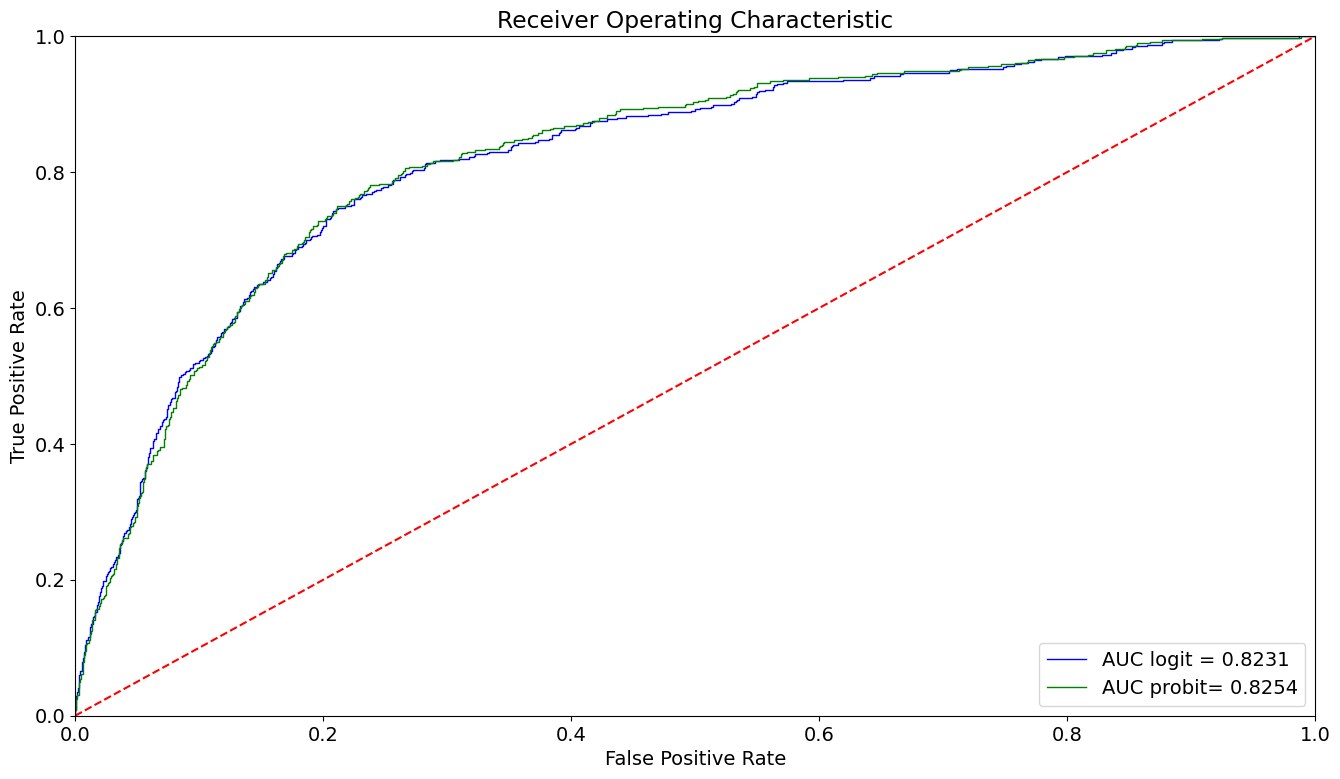

In [ ]:
figure(figsize=(16, 9), dpi=100)
plt.rcParams.update({'font.size': 14})

fpr_log, tpr_log, threshold_log = roc_curve(df['Churn'], logit_mod.predict(sm.add_constant(X)))
roc_auc_log = auc(fpr_log, tpr_log)
fpr_prob, tpr_prob, threshold_prob = roc_curve(df['Churn'], probit_mod.predict(sm.add_constant(X)))
roc_auc_prob = auc(fpr_prob, tpr_prob)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log, tpr_log, 'b', label = 'AUC logit = %0.4f' % roc_auc_log, linewidth=1)
plt.plot(fpr_prob, tpr_prob, 'g', label = 'AUC probit= %0.4f' % roc_auc_prob, linewidth=1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(f'AUC for Logit:\t{roc_auc_log:.4}')
print(f'AUC for Probit:\t{roc_auc_prob:.4}')

AUC for Logit:	0.8231
AUC for Probit:	0.8254


### Sum up по метрикам + какую модель я бы выбрал
Мне логит больше понравился.
- $R^2$ выше
- По Confusion matrix видно, что он лучше предсказывает как раз отток
- Все метрики, основанные на confusion matrix говорят, что logit лучше
- AUC у пробита выше, ну тут уж извините, куда деваться

### Профиль среднего "клиента"
Посмотреть на профиль среднего "клиента" (наблюдения). Какие переменные надо изменить, чтобы верояность ухода клиента снизилась?

Модальный не сваливающий клиент

In [ ]:
df[df['Churn'] == False].drop('State', axis=1).mode(axis=0, numeric_only=True).head(3)

Account length  Area code  ...  Customer service calls  Churn
0            87.0      415.0  ...                     1.0  False
1             NaN        NaN  ...                     NaN    NaN
2             NaN        NaN  ...                     NaN    NaN

[3 rows x 19 columns]

Модальный сваливающий клиент

In [ ]:
df[df['Churn'] == True].drop('State', axis=1).mode(axis=0, numeric_only=True).head(3)

Account length  Area code  ...  Customer service calls  Churn
0           105.0      415.0  ...                     1.0   True
1           119.0        NaN  ...                     NaN    NaN
2             NaN        NaN  ...                     NaN    NaN

[3 rows x 19 columns]

Кажется, мы хотим увеличить длительность звонков (в любое время суток), при этом стоимость как будто не влияет на отток человеков.\
**Вот и первая допметрика**: хочу посчитать среднюю продолжительность звонка. Видимо, дропаем всё-таки деньги, а не минуты, как я выше писал.

### Предикты
- У вас не всегда будут функции типа `LogisticRegressionCV`, поэтому почитайте про [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Подумайте, какие еще признаки можно добавить в вашу модель. На этом этапе не бойтесь кол-ва признаков, чем больше, тем лучше. *{Дополнительно: почитайте про [`RFECV`](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py), попробуйте его применить}*
- При наличии достаточного кол-ва наблюдений, хорошей стратегией является использование только части данных для расчета модели. Используя [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) выделите наблюдения для обучения.
- Создайте стратифицированные фолды на обучающей выборке
- На практике нам приходится выбирать между различными метриками качества. В этой задаче будем использовать ROC AUC
- Используя `GridSearchCV` и [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression) подберите оптимальный гиперпараметр для l1, l2 регуляризаций. Помните, что вы хотите, чтобы оптимальный гиперпараметр был выбран согласно метрике ROC AUC. Почитайте, как это сделать в GridSearchCV
- Нарисуйте графики, как меняется ваш score в зависимости от значения гиперпараметра

#### GridSearchCV

У вас не всегда будут функции типа `LogisticRegressionCV`, поэтому почитайте про `GridSearchCV`
- Всегда юзаю родной склерновский `GridSearchCV` и прекрасно себя чувствую. Спасибо, курс по машинке на Физтехе.


#### Работа с признаками

Подумайте, какие еще признаки можно добавить в вашу модель. На этом этапе не бойтесь кол-ва признаков, чем больше, тем лучше. \{Дополнительно: почитайте про `RFECV`, попробуйте его применить\}
- Ок.
    - Сначала дропну стоимость
    - Дропну area code и plan'ы. И всё про vmail туда же.
    - Сделаю новую метрику -- продолжительность разговора.

Фильтруем колонки с "charge" в названии

In [ ]:
print(df.shape)
print((df[df.columns.drop(list(df.filter(regex='charge')))]).shape)

(3333, 20)
(3333, 16)


In [ ]:
df = df[df.columns.drop(list(df.filter(regex='charge')))]

Дропаем Area code, * plan, vmail

In [ ]:
df = df[df.columns.drop(list(df.filter(regex='plan')))].drop(['Area code', 'Number vmail messages'], axis=1)

Новая метрика для продолжительности разговора.

In [ ]:
daytime = [
           'day',
           'night',
           'eve',
           'intl',
]
for time in daytime:
    df[f'{time} avg minutes'] = df[f'Total {time} minutes'] / df[f'Total {time} calls']
df.head()

State  Account length  ...  eve avg minutes  intl avg minutes
0     16             128  ...         1.993939          3.333333
1     35             107  ...         1.898058          4.566667
2     31             137  ...         1.101818          2.440000
3     35              84  ...         0.703409          0.942857
4     36              75  ...         1.215574          3.366667

[5 rows x 16 columns]

#### Сплит + фолды
При наличии достаточного кол-ва наблюдений, хорошей стратегией является использование только части данных для расчета модели. Используя `train_test_split` выделите наблюдения для обучения.

Создайте стратифицированные фолды на обучающей выборке

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y,
                                                  random_state=42,
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  )

#### И это всё? Час уговоров ради минуты позора?

Используя `GridSearchCV` и `LogisticRegression` подберите оптимальный гиперпараметр для `l1`, `l2` регуляризаций. Помните, что вы хотите, чтобы оптимальный гиперпараметр был выбран согласно метрике `ROC AUC`. Почитайте, как это сделать в `GridSearchCV`

In [ ]:
grid_values = {'penalty': ['l1','l2'], "C": np.logspace(-3,3,7)}
lr = LogisticRegression()
model_lr = GridSearchCV(lr, param_grid=grid_values, cv=5, scoring=make_scorer(roc_auc_score))
model_lr.fit(xtrain, ytrain)

print("tuned hyperparameters : (best parameters) ", model_lr.best_params_)
print("AUC :", model_lr.best_score_)

tuned hyperparameters : (best parameters)  {'C': 1.0, 'penalty': 'l2'}
AUC : 0.5401260124689118


In [ ]:
logreg = LogisticRegression(**model_lr.best_params_)
logreg.fit(xtrain, ytrain)
print("AUC:", logreg.score(xvalid, yvalid))


AUC: 0.8323353293413174


Ok bois ok bois ok bois ok bois

#### Визуализация
Не зря же нас этой штуке учат))

In [ ]:
scores = model_lr.cv_results_['mean_test_score']
scores = scores[~np.isnan(scores)]

In [ ]:
params = model_lr.cv_results_['params']

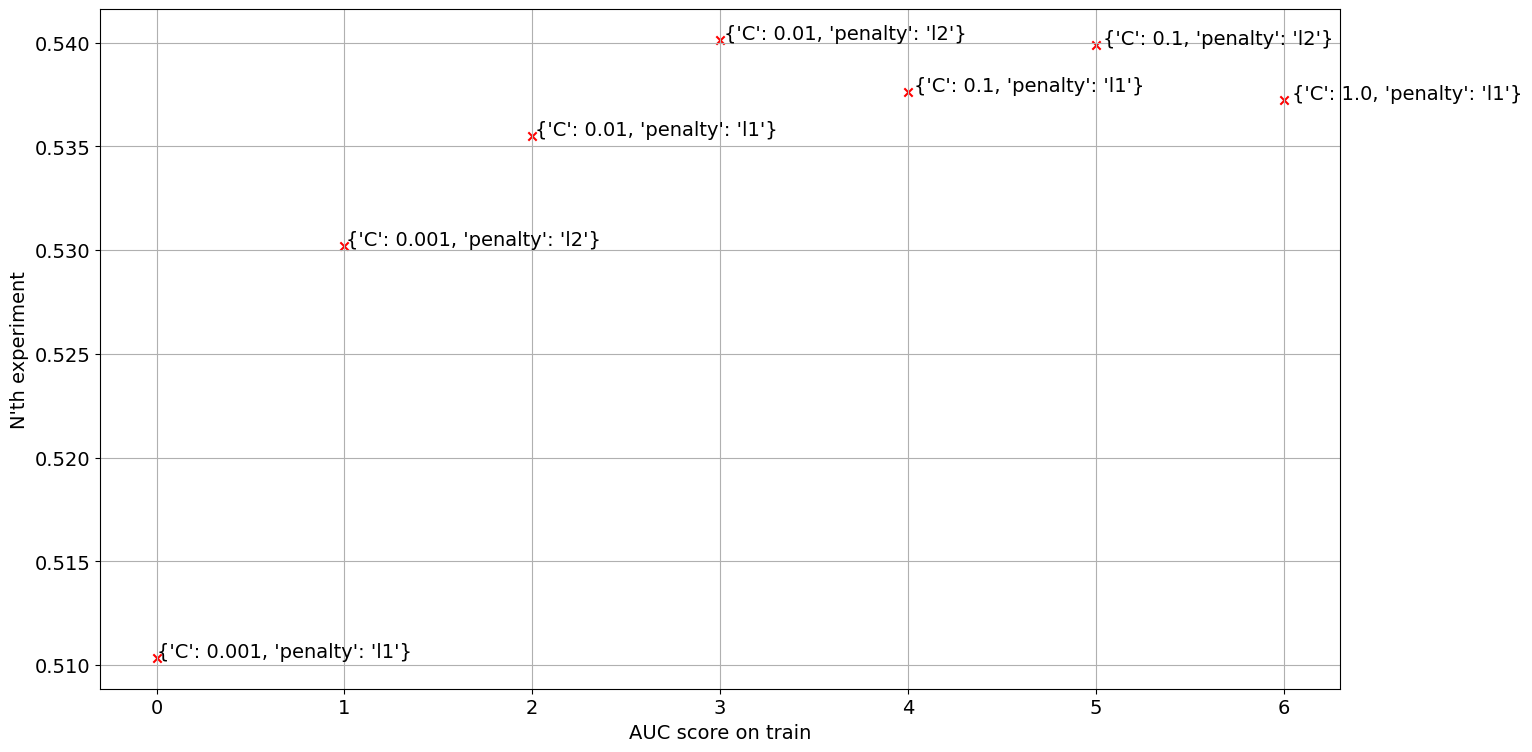

In [ ]:
figure(figsize=(16, 9), dpi=100)
plt.rcParams.update({'font.size': 14})

for num, val in enumerate(scores):
    plt.annotate(params[num], (num, val), textcoords='offset points')
    plt.scatter(num, val, marker='x', color='red')

plt.grid()
plt.xlabel('AUC score on train')
plt.ylabel("N'th experiment")
plt.show()

Challenge completed.

# №3 (40 баллов)

- Ладно, пришла пора для чего более сложного
- В этой задаче вы сами все решаете. Более того, у вас будут даже чужие ноутбуки
- Если вы проведете такой же анализ, что и выше, то балл за это задание будет равен 10/40
- Чтобы получить максимальный балл за это задание, то вам нужно будет провести полноценное исследование

- Итак, представьте себе следующую ситуацию
- Вы участвуете в создании продукта/модели по предсказанию инсульта 
- Вы - главный аналитик, который отвечает за создание модели и презентацию ее результатов
- Проблема в том, что вы единственный аналитик в команде. Все остальные члены команды **не имеют математического бэкграунда, они не знают никаких моделей, они никогда не занимались программированием**. Они все медики.
- Вы знаете, что для тестривания модели на первом этапе подойдет [этот](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) замечательный датасет. Там есть примеры различного анализа и моделей
- Но вы не можете просто взять примеры оттуда:
    - Во-первых, ваша модель должна быть логистической или пробит 
    - Во-вторых, посмотрите на то, как меняется вероятность инсульта в зависимости от характеристик пациента
    - В-третьих, подумайте над тем, как можно поменять/улучшить эту модель, чтобы обеспечить **наилучшее предсказание**. Подумайте, какую метрику вы будете использовать для этой задачи. Обоснуйте выбор метрики.
- Еще важный момент. Вы отправите, получившееся исследование команде, поэтому оно не должно быть большим (время на прочтение и понимание того, что происходит, не должно занимать более 10-15 минут). Помните, что у команды есть и другие задачи, поэтому позаботьтесь, чтобы исследование было:
    - Структурированным. Можете использовать [классический](https://blogs.lse.ac.uk/impactofsocialsciences/2018/05/21/writing-a-page-turner-how-to-tell-a-story-in-your-scientific-paper/) подход к научному исследованию и добавить то, как делают [консультанты](https://strategyu.co/mckinsey-structured-problem-solving-secrets/)
    - Отвечало на поставленную задачу
    - Было самодостаточным (в одном jupyter файле, проще говоря)
    - Воспроизводимым (увижу, что явно не прописываете `seed`, если/где надо, поставлю 0 за это задание)
    - Было не стыдно показать другим людям (если графики будут без подписей осей и названия, как минимум, поставлю 0)